В этом практическом задании мы рассмотрим задачу восстановления синтаксических зависимостей между словами в предложении на примере предсказания результата вычисления математического выражения. Пример данных, с которыми нам предстоит работать можно видеть ниже.

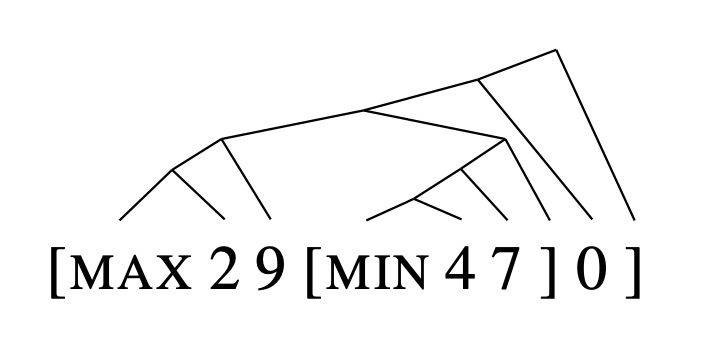

Над математическим выражением можно видеть дерево синтаксического разбора. Человеческая аннотация для получения таких деревьев занимает очень много времени и требует специальных знаний от аннотаторов. Поэтому мы заинтересованы в создании моделей машинного обучения, которые могли бы автоматически восстанавливать такого рода зависимости из данных в режиме "без учителя". В данном задании мы будем реализовывать и обучать модель со скрытыми переменными, в которой в качестве скрытых переменных будет выступать такой граф. Данный подход позволит решить проблему отсутствия аннотаций и помимо решения задачи вычисления результата математического выражения, еще и позволит автоматически восстанавливать деревья зависимостей из данных.

Перейдем к делу, ниже идут ячейки, которые загружают нужные нам модули и импортируют библиотеки.

In [2]:
!git clone https://github.com/agadetsky/sochischool.git

Cloning into 'sochischool'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 278 (delta 18), reused 19 (delta 8), pack-reused 231
Receiving objects: 100% (278/278), 50.92 MiB | 30.62 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Checking out files: 100% (195/195), done.


In [3]:
!pip install -qU git+https://github.com/harvardnlp/pytorch-struct

In [4]:
import random
import sys
sys.path.append('/content/sochischool/')

In [5]:
import torch
import numpy as np
from torch_struct import DependencyCRF
from tqdm import tqdm

In [17]:
import listops.data as _data
import listops.model as _model
import listops.data_processing.python.loading as _loading
from listops.school_utils import compute_metrics
from listops.model_modules.sampler import DependencySampler, BinaryIndependentSampler

In [7]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [8]:
%%capture

datasets = _data.get_datasets(
    "var_5_50_nosm_20000",
    datadirpath="/content/sochischool/listops/data_processing/python/listops/data"
  )

In [10]:
%%capture

train_loader, val_loader, test_loader  = _data.get_dataloaders(datasets, batchsize=50)

Вся работа с данными была реализована за вас. Так как мы работаем с синтетическими данными, то нам известны правильные деревья разбора, которые мы в будущем будем использовать для оценивания качества их восстановления.

$$
\begin{align*}
x & \in \{0, \dots \lvert V \rvert - 1\}^{n} \text{ - последовательность длины } n,\ V \text{ - словарь используемых символов} \\
y & \in \{0, \dots, 9\} \text{ - метки класса (результат выражения - число от 0 до 9)}\\
\text{arcs} & \in \{0, 1\}^{n \times n} \text{ - граф зависимостей между словами в } x\ (\text{arcs}_{ij} = 1 \implies x_i \rightarrow x_j)
\end{align*}
$$

In [11]:
x, y, arcs, lengths, depths = next(iter(train_loader))

In [29]:
def print_eq(x, y):
  print(" ".join([_loading.ix_to_word[elem] for elem in x if elem != _loading.word_to_ix["<PAD>"]]) + " = " + str(y.item()))

In [32]:
idx = 33
print_eq(x[idx].cpu().numpy().tolist(), y[idx])

[MIN 8 8 9 [MED 1 6 0 ] ] = 1


Теперь перейдем к модели, ниже можно видеть диаграмму модели, которую мы будем использовать.

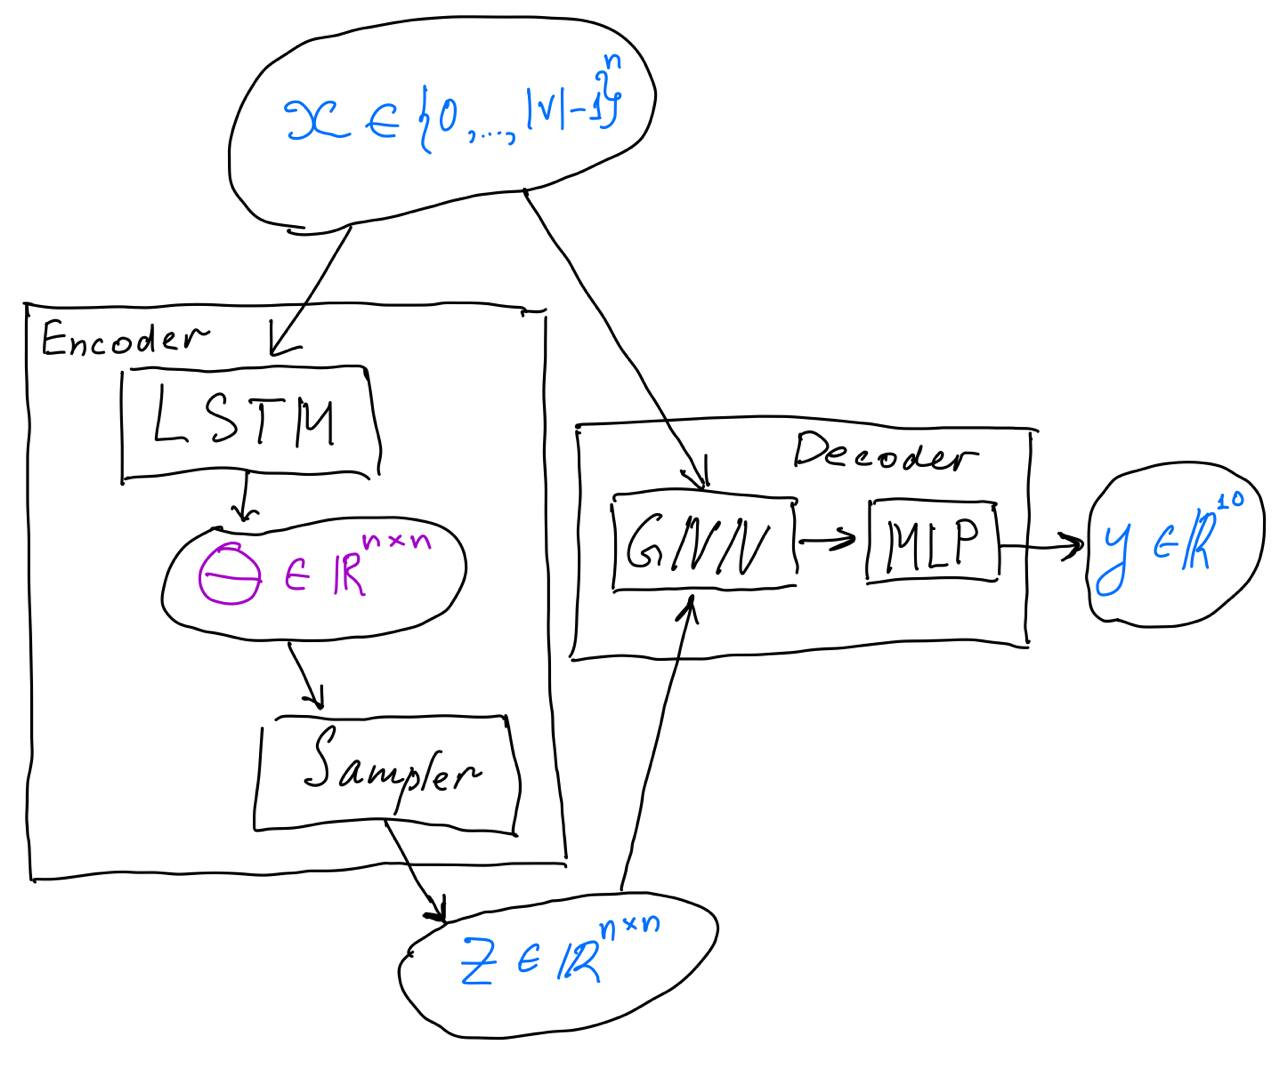

Модель представляет собой архитектуру вида encoder-decoder. Encoder по входу $x$ выдает параметры распределения $\theta$ над графами. Модуль `Sampler` выдает сэмпл из соответствующего распределения над графами. А decoder - классификатор (графовая нейронная сеть), который по графу и последовательности $x$ выдает предсказания класса. Большая часть модели реализована за вас, вам нужно реализовать только модуль `Sampler`.

На первом семинаре мы не будем учитывать знание о том, что граф синтаксических зависимостей имеет определенную структуру, и для простоты будем моделировать распределение над ребрами как независимые бинарные случайные величины, а именно:

$$p(z|x, \theta) = \prod_{i=1}^{n}\prod_{j=1}^{n}p(z_{ij} | x, \theta_{ij}) = \prod_{i=1}^{n}\prod_{j=1}^{n} \text{Bin}(z_{ij}|\theta_{ij}(x))$$

где $\theta$ - нейронная сеть (encoder), выдающая параметры распределения.

Для того, чтобы граф вычислений модели был дифференцируемым воспользуемся Gumbel-Softmax трюком для нашего распределения, а именно:

$$
\begin{align*}
u_{ij} & \sim \text{Uniform}(0, 1) \\
l_{ij} & = \text{log}(u_{ij}) - \text{log}(1 - u_{ij}) \\
\hat{\theta}_{ij} & = (l_{ij} + \theta_{ij}) / \tau \\
\hat{z}_{ij} & = \sigma(\hat{\theta}_{ij})
\end{align*}
$$

Известно, что при устремлении температуры $\tau$ к нулю, релаксация переходит в бинарное дискретное распределение, но градиенты по $\theta$ соответственно становятся неинформативными, поэтому использование слишком низких температур нежелательно. На практике чаще всего используют $\tau=1.0$, но можно поиграться с этим гиперпараметром.


Ниже вам нужно реализовать сэмплер, для описанных выше распределений.
Метод `inject_noise` по параметрам распределения $\theta$ выдает зашумленную версию $\hat{\theta}$. Метод `sample` использует `inject_noise` для сэмплирования либо релаксации (`mode=soft`), либо бинарного дискретного сэмпла (`mode=hard`).

In [ ]:
class BinarySampler(BinaryIndependentSampler):

    def __init__(self, noise, tau):
        assert noise in set(['logistic'])
        super(BinarySampler, self).__init__("soft", noise, tau)

    def inject_noise(self, theta):
        if self.noise == "logistic":
            u = torch.distributions.utils.clamp_probs(torch.rand_like(theta))
            noise = u.log() - u.neg().log1p()
            return (theta + noise) / self.tau

    def sample(self, theta, lengths, mode):
        if mode == "soft":
            return self.inject_noise(theta).sigmoid()
        elif mode == "hard":
            return (self.inject_noise(theta.detach()) > 0.0).float()

Мы на финишной прямой, осталось реализовать функцию `training` для обучения модели. У нас задача классификации, соответственно оптимизируемый функционал выглядит следующим образом:

$$\mathbb{E}_{(x, y)} \mathbb{E}_{\hat{z}} \text{CrossEntropy}(\hat{y}_{\phi}(x, \hat{z}), y) \rightarrow \min\limits_{\theta, \phi}$$

где $\hat{y}_{\phi}(x, \hat{z})$ - нейронная сеть (decoder), выдающая предсказания модели.

Для удобства ниже опишем сигнатуру функции `training` и модели `m`

`m` - это `torch.nn.Module`, поэтому имеем следующее:

`m(x, arcs, lengths)` выдает предсказания $\hat{y}_{\phi}(x, \hat{z})$

`m.sample` - это сэмпл $\hat{z}$ для последнего прогнанного $x$

В режиме `m.train()`, `m.sample` - это релаксация (`mode=soft` в `Sampler`), а в режиме `m.eval()`, `m.sample` - это дискретное распределение (`mode=hard` в `Sampler`).
 

In [11]:
def training(m, train_loader, opt, num_epochs):
    m.train()
    for _ in range(num_epochs):
        for batch_idx, (x, y, arcs, lengths, depths) in enumerate(tqdm(train_loader)):
            opt.zero_grad()

            x = x.cuda()
            y = y.cuda()
            arcs = arcs.cuda()
            lengths = lengths.cuda()
            
            with torch.set_grad_enabled(True):
                pred_logits = m(x, arcs, lengths)
                loss = torch.nn.functional.cross_entropy(pred_logits, y)
                loss.backward()
                opt.step()

Также реализуем функцию `validation` для валидации модели на отложенной выборке. Тут все аналогично функции `training`. Дополнительно, помимо функции потерь, посчитайте метрики: качество предсказаний модели, а также метрики качества восстановления графа связей - precision и recall. Для подсчета precision и recall воспользуйтесь функцией `compute_metrics(m.sample, arcs, lengths)`, которая была импортирована в начале ноутбука.

In [12]:
def validation(m, val_loader):
    m.eval()
    val_losses = []
    val_accs = []
    val_precs = []
    val_recs = []
    for batch_idx, (x, y, arcs, lengths, depths) in enumerate(tqdm(val_loader)):
        x = x.cuda()
        y = y.cuda()
        arcs = arcs.cuda()
        lengths = lengths.cuda()
        with torch.no_grad():
          pred_logits = m(x, arcs, lengths)
          loss = torch.nn.functional.cross_entropy(pred_logits, y)
          acc = (pred_logits.argmax(-1) == y).float().mean()
          precision, recall = (compute_metrics(m.sample, arcs, lengths))

        val_losses.append(loss.item())
        val_accs.append(acc.item())
        val_precs.append(precision.item())
        val_recs.append(recall.item())
    return val_losses, val_accs, val_precs, val_recs

Пришло время обучить модель.

In [13]:
sampler = BinarySampler("logistic", 1.0)
m = _model.get_school_model(sampler)
m.cuda()
opt = torch.optim.AdamW(m.parameters())
training(m, train_loader, opt, num_epochs=2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
100%|██████████| 2000/2000 [02:56<00:00, 11.33it/s]


In [14]:
val_losses, val_accs, val_precs, val_recs = validation(m, val_loader)

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


In [15]:
np.mean(val_losses)

0.530943063646555

In [16]:
np.mean(val_accs)

0.8084000408649444

In [17]:
np.mean(val_precs)

0.10717825219035149

In [18]:
np.mean(val_recs)

0.40346491038799287

Здесь про надобность структуры (картинку из perturb and parse) и про projective sampler

In [ ]:
class ProjectiveSampler(DependencySampler):

    def __init__(self, noise, tau):
        assert noise in set(['gumbel', 'gaussian'])
        super(ProjectiveSampler, self).__init__("soft", noise, tau, True, False)
        
    def inject_noise(self, theta):
        if self.noise == "gumbel":
            u = torch.distributions.utils.clamp_probs(torch.rand_like(theta))
            noise = u.log().neg().log().neg()
            return (theta + noise) / self.tau
        elif self.noise == "gaussian":
            noise = torch.randn_like(theta)
            return (theta + noise) / self.tau

    def sample(self, theta, lengths, mode):
        if mode == "soft":
            return DependencyCRF(self.inject_noise(theta), lengths).marginals
        elif mode == "hard":
            return DependencyCRF(self.inject_noise(theta), lengths).argmax.detach()

In [19]:
sampler = ProjectiveSampler("gumbel", 1.0)
m = _model.get_school_model(sampler)
m.cuda()
opt = torch.optim.AdamW(m.parameters())
training(m, train_loader, opt, num_epochs=2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
100%|██████████| 2000/2000 [12:03<00:00,  2.77it/s]


In [20]:
val_losses, val_accs, val_precs, val_recs = validation(m, val_loader)

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [21]:
np.mean(val_losses)

0.7142713025212288

In [22]:
np.mean(val_accs)

0.7508000373840332

In [23]:
np.mean(val_precs)

0.6151826977729797

In [24]:
np.mean(val_recs)

0.6151826977729797